In [3]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

##**1).Data Exploration**

In [4]:
! pip install kaggle

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d abhi8923shriv/sentiment-analysis-dataset

 90% 49.0M/54.4M [00:00<00:00, 176MB/s]
100% 54.4M/54.4M [00:00<00:00, 166MB/s]


In [7]:
dataset = '/content/sentiment-analysis-dataset.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [8]:
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')
twitter_data.head()

polarity of tweet   id of the tweet             date of the tweet  \
0                   0       1467810672  Mon Apr 06 22:19:49 PDT 2009   
1                   0       1467810917  Mon Apr 06 22:19:53 PDT 2009   
2                   0       1467811184  Mon Apr 06 22:19:57 PDT 2009   
3                   0       1467811193  Mon Apr 06 22:19:57 PDT 2009   
4                   0       1467811372  Mon Apr 06 22:20:00 PDT 2009   

      query           user                                 text of the tweet   
0  NO_QUERY  scotthamilton  is upset that he can't update his Facebook by ...  
1  NO_QUERY       mattycus  @Kenichan I dived many times for the ball. Man...  
2  NO_QUERY        ElleCTF    my whole body feels itchy and like its on fire   
3  NO_QUERY         Karoli  @nationwideclass no, it's not behaving at all....  
4  NO_QUERY       joy_wolf                      @Kwesidei not the whole crew

In [10]:
column_names = ['target','id','time','query','user','text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', names = column_names ,encoding='ISO-8859-1')
twitter_data.head()

<ipython-input-10-d1af6601a2c5>:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', names = column_names ,encoding='ISO-8859-1')


target               id                          time  \
0  polarity of tweet   id of the tweet             date of the tweet   
1                   0       1467810672  Mon Apr 06 22:19:49 PDT 2009   
2                   0       1467810917  Mon Apr 06 22:19:53 PDT 2009   
3                   0       1467811184  Mon Apr 06 22:19:57 PDT 2009   
4                   0       1467811193  Mon Apr 06 22:19:57 PDT 2009   

      query           user                                               text  
0     query           user                                 text of the tweet   
1  NO_QUERY  scotthamilton  is upset that he can't update his Facebook by ...  
2  NO_QUERY       mattycus  @Kenichan I dived many times for the ball. Man...  
3  NO_QUERY        ElleCTF    my whole body feels itchy and like its on fire   
4  NO_QUERY         Karoli  @nationwideclass no, it's not behaving at all....

In [11]:
twitter_data.drop(index=0,inplace=True)

In [12]:
twitter_data.head()

target          id                          time     query           user  \
1      0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton   
2      0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus   
3      0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF   
4      0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli   
5      0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf   

                                                text  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  
5                      @Kwesidei not the whole crew

In [13]:
twitter_data.shape

(1048572, 6)

In [14]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 1 to 1048572
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1048572 non-null  object
 1   id      1048572 non-null  object
 2   time    1048572 non-null  object
 3   query   1048572 non-null  object
 4   user    1048572 non-null  object
 5   text    1048572 non-null  object
dtypes: object(6)
memory usage: 48.0+ MB


In [15]:
twitter_data.isnull().sum()

target    0
id        0
time      0
query     0
user      0
text      0
dtype: int64

In [16]:
twitter_data['target'].value_counts()

0    668925
4    248576
0    131071
Name: target, dtype: int64

In [17]:
twitter_data.replace({'target':{4:1}},inplace=True)

In [18]:
twitter_data['target'].value_counts()

0    668925
1    248576
0    131071
Name: target, dtype: int64

0 ---> Negative Tweet

1 ---> Positive Tweet

##**2).Data PreProcessing**

In [19]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [20]:
# Load NLTK stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Lowercasing and handling special characters
twitter_data['processed_text'] = twitter_data['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x.lower()))

# Tokenization and removing stop words
twitter_data['tokenized_text'] = twitter_data['processed_text'].apply(lambda x: word_tokenize(x))
twitter_data['filtered_text'] = twitter_data['tokenized_text'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
twitter_data['lemmatized_text'] = twitter_data['filtered_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Display the preprocessed data
print(twitter_data[['text', 'lemmatized_text']])

                                                      text  \
1        is upset that he can't update his Facebook by ...   
2        @Kenichan I dived many times for the ball. Man...   
3          my whole body feels itchy and like its on fire    
4        @nationwideclass no, it's not behaving at all....   
5                            @Kwesidei not the whole crew    
...                                                    ...   
1048568           My GrandMa is making Dinenr with my Mum    
1048569  Mid-morning snack time... A bowl of cheese noo...   
1048570  @ShaDeLa same here  say it like from the Termi...   
1048571             @DestinyHope92 im great thaanks  wbuu?   
1048572               cant wait til her date this weekend    

                                           lemmatized_text  
1        [upset, cant, update, facebook, texting, might...  
2        [kenichan, dived, many, time, ball, managed, s...  
3                   [whole, body, feel, itchy, like, fire]  
4          

##**3).Exploratory Data Analysis (EDA)**

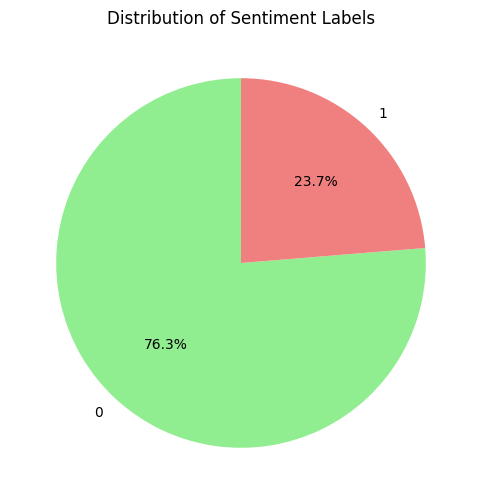

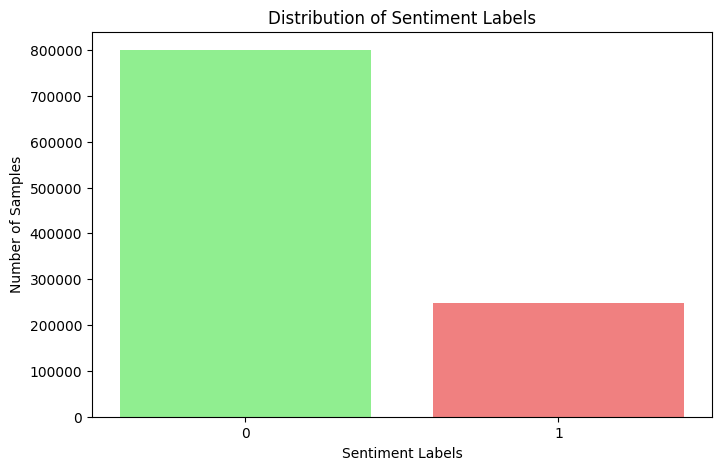

In [21]:
twitter_data['target'] = pd.to_numeric(twitter_data['target'], errors='coerce')
sentiment_distribution = twitter_data['target'].value_counts()

# Visualize the distribution using a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
plt.title('Distribution of Sentiment Labels')
plt.show()

# Visualize the distribution using a histogram
plt.figure(figsize=(8, 5))
plt.bar(sentiment_distribution.index.astype(str), sentiment_distribution.values, color=['lightgreen', 'lightcoral'])
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Labels')
plt.ylabel('Number of Samples')
plt.show()


##**4).Text Vectorization:**

**Using Word Embeddings (Word2Vec):**

In [22]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Tokenize the preprocessed text
tokenized_text = twitter_data['lemmatized_text'].apply(lambda x: word_tokenize(' '.join(x)))

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

# Function to calculate the mean vector for a sentence
def get_sentence_vector(sentence):
    vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

# Apply the function to obtain word embeddings for each sentence
word_embeddings = tokenized_text.apply(get_sentence_vector)

# Convert word embeddings to DataFrame (for illustration purposes)
word_embeddings_df = pd.DataFrame(word_embeddings.tolist(), columns=[f'embedding_{i+1}' for i in range(word2vec_model.vector_size)])

# Display Word Embeddings DataFrame
print(word_embeddings_df)


         embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0          -1.940268     0.253536     0.620418     0.908552     0.481809   
1          -1.687384     0.632577     0.709189    -0.183682     0.817774   
2          -2.721316     1.425205     0.488804     1.070473     0.493791   
3          -1.083767    -0.458127     0.734744     0.233645    -0.257541   
4          -0.698316    -0.160261    -0.068984     0.037341     0.025874   
...              ...          ...          ...          ...          ...   
1048567    -0.779684     0.280478    -0.360636     0.297832    -0.193783   
1048568    -2.105235    -0.057198     1.061015     1.052139     0.564232   
1048569    -1.922531     0.352106    -0.323354     0.250508     0.779905   
1048570    -0.716557     0.129667     0.243884     0.025298    -0.472183   
1048571    -1.835401    -0.127977     1.381770    -1.118840     0.908756   

         embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  \
0         

##**5).Model Selection:**

In [49]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import Sequential
from keras.utils import to_categorical
from keras.layers import Dense,SimpleRNN,Embedding,Flatten

In [51]:
train_ds = pd.read_csv('train.csv',encoding='latin1');
validation_ds = pd.read_csv('test.csv',encoding='latin1');

In [52]:
train_ds = train_ds[['text','sentiment']]
validation_ds = validation_ds[['text','sentiment']]

In [53]:
train_ds['text'].fillna('',inplace=True)
validation_ds['text'].fillna('',inplace=True)

In [54]:
def func(sentiment):
    if sentiment =='positive':
        return 0;
    elif sentiment =='negative':
        return 1;
    else:
        return 2;
train_ds['sentiment'] = train_ds['sentiment'].apply(func)
validation_ds['sentiment'] = validation_ds['sentiment'].apply(func)

In [55]:
x_train = np.array(train_ds['text'].tolist())
y_train = np.array(train_ds['sentiment'].tolist())
x_test = np.array(validation_ds['text'].tolist())
y_test = np.array(validation_ds['sentiment'].tolist())

In [56]:
x_train

array([' I`d have responded, if I were going',
       ' Sooo SAD I will miss you here in San Diego!!!',
       'my boss is bullying me...', ...,
       ' Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx',
       ' But it was worth it  ****.',
       '   All this flirting going on - The ATG smiles. Yay.  ((hugs))'],
      dtype='<U159')

In [57]:
y_train

array([2, 1, 1, ..., 0, 0, 2])

In [58]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [59]:
y_train

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [60]:
tokenizer = Tokenizer(num_words=20000)

In [61]:
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)

In [62]:
len(tokenizer.word_index)

28614

In [63]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [64]:
from keras.utils import pad_sequences
x_train = pad_sequences(x_train, padding='post', maxlen=35)  # Set maxlen to 35
x_test = pad_sequences(x_test, padding='post', maxlen=35)

In [65]:
x_train[0]

array([   1,  162,   19, 7713,   71,    1,  151,   49,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [66]:
x_train.shape

(27481, 35)

In [67]:
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=5, input_length=35))
model.add(SimpleRNN(32,return_sequences=False))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 5)             100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1216      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 101315 (395.76 KB)
Trainable params: 101315 (395.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
859/859 [==============================] - 14s 14ms/step - loss: 0.9584 - accuracy: 0.5193 - val_loss: 0.7263 - val_accuracy: 0.7323
Epoch 2/10
859/859 [==============================] - 12s 14ms/step - loss: 0.7229 - accuracy: 0.6923 - val_loss: 0.6006 - val_accuracy: 0.7670
Epoch 3/10
859/859 [==============================] - 8s 10ms/step - loss: 0.5836 - accuracy: 0.7665 - val_loss: 0.5952 - val_accuracy: 0.7593
Epoch 4/10
859/859 [==============================] - 11s 13ms/step - loss: 0.4911 - accuracy: 0.8136 - val_loss: 0.6031 - val_accuracy: 0.7580
Epoch 5/10
859/859 [==============================] - 11s 13ms/step - loss: 0.4116 - accuracy: 0.8528 - val_loss: 0.6533 - val_accuracy: 0.7456
Epoch 6/10
859/859 [==============================] - 10s 11ms/step - loss: 0.3498 - accuracy: 0.8764 - val_loss: 0.7047 - val_accuracy: 0.7416
Epoch 7/10
859/859 [==============================] - 8s 10ms/step - loss: 0.3014 - accuracy: 0.8972 - val_loss: 0.7233 - val_accuracy: 0

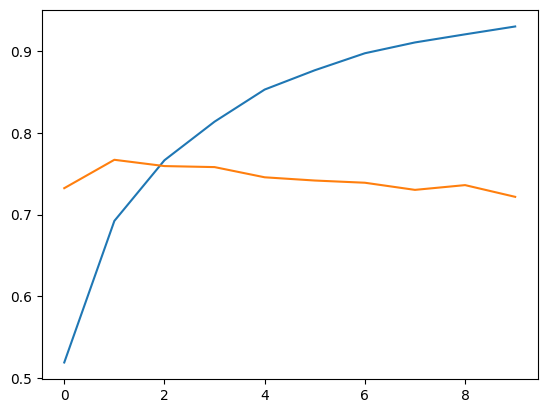

In [70]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [71]:
# Prediction 1
text = "The movie was bad bad bad, i will not recommend this movie to anyone"

new_text_seq = tokenizer.texts_to_sequences([text])
new_text_padded = pad_sequences(new_text_seq, padding='post', maxlen=35)  # Use the max_len determined during training
predictions = model.predict(new_text_padded)
predicted_class_index = predictions.argmax(axis=-1)
if predicted_class_index[0] == 0:
    print("Postive Sentiment");
elif predicted_class_index[0] == 1:
    print("Negative Sentiment")
else:
    print("Neutral Sentiment")

1/1 [==============================] - 0s 206ms/step
Negative Sentiment


In [72]:
# Prediction 2

text = "The movie was good, i will recommend this movie to anyone"

new_text_seq = tokenizer.texts_to_sequences([text])
new_text_padded = pad_sequences(new_text_seq, padding='post', maxlen=35)  # Use the max_len determined during training
predictions = model.predict(new_text_padded)
predicted_class_index = predictions.argmax(axis=-1)
if predicted_class_index[0] == 0:
    print("Postive Sentiment");
elif predicted_class_index[0] == 1:
    print("Negative Sentiment")
else:
    print("Neutral Sentiment")

1/1 [==============================] - 0s 26ms/step
Postive Sentiment
